In [2]:
import pandas as pd
import re
from nltk import word_tokenize
import nltk.tokenize.punkt
import numpy as np
from nltk import sent_tokenize
import codecs
import nltk.corpus
import nltk.tokenize.punkt
import nltk.stem.snowball
import string
from nltk import word_tokenize
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Dense, Dropout, LSTM, Masking, Bidirectional, GRU, SimpleRNN
from tensorflow.keras import optimizers
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import model_selection, naive_bayes, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.metrics import Recall, Precision


Using TensorFlow backend.


### Reading from file and setting column headers

In [3]:
df = pd.read_csv("amazon_dataset_3.csv")
df_Test = pd.read_csv("amazon_dataset_test_3.csv")

In [4]:
print(df.describe())
df_Test.rename(columns={'reviewText':'Review', 'summary': 'Summary'}, inplace=True)
df_Test.describe()

                 reviewText   summary       Class
count                 15853     15853       15853
unique                15845     12857           5
top     It arrived damaged!  One Star  Operations
freq                      2      1091        4968


,Review,Summary,Class
count,1603,1603,1603
unique,1602,1413,5
top,Item arrived damaged.,One Star,Operations
freq,2,118,502


### Preprocessing reviews

In [ ]:
def create_tokens(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r"[^A-Za-z0-9\s]+", '', sentence)        
    sentence_tokens = nltk.word_tokenize(sentence)
    sentence_tokens = ' '.join(sentence_tokens)
    return sentence_tokens

In [6]:
df['reviewText'] = df['reviewText'].apply(create_tokens)
df['summary'] = df['summary'].apply(create_tokens)
df['Review_withSummary'] = df['summary'] + " " + df['reviewText']

df_Test['Review'] = df_Test['Review'].apply(create_tokens)
df_Test['Summary'] = df_Test['Summary'].apply(create_tokens)
df_Test['Review_withSummary'] = df_Test['Summary'] + " " + df_Test['Review']

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
# df_Test = df_Test.sample(frac=1).reset_index(drop=True)

### Encoding and Tokenising 

In [8]:
label_encoder = LabelEncoder()
label_encoder.fit(df['Class'])

df['class_encoded']= label_encoder.transform(df['Class'])
df_Test['class_encoded']= label_encoder.transform(df_Test['Class'])


In [9]:
tokenizer = Tokenizer()
sentence_sequence_train = tokenizer.fit_on_texts(df['Review_withSummary'])

sentence_sequence_test = tokenizer.fit_on_texts(df_Test['Review_withSummary'])
sentence_sequence_test = tokenizer.texts_to_sequences(df_Test['Review_withSummary'])

pad_sequence_test = pad_sequences(sentence_sequence_test, maxlen = 100)

sentence_sequence_train = tokenizer.texts_to_sequences(df['Review_withSummary'])
pad_sequence_train = pad_sequences(sentence_sequence_train, maxlen = 100)

# pad_sequence_Summary = pad_sequences(sentence_sequence_summary, maxlen=Seq_len)

In [10]:
Max_Words = len(tokenizer.word_index) + 1

### Loading GloVe matrix

In [11]:
embedding_matrix = np.zeros((Max_Words, 300))

In [12]:
embeddings_index = {}

f = open("glove.6B.300d.txt", encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
        
print('Found %s word vectors.' % len(embeddings_index))

for word, i in tokenizer.word_index.items():
    if i >= Max_Words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


### computing class weights to handle skewed dataset

In [13]:
class_ratio = df['class_encoded'].value_counts(normalize=True)
max_value = class_ratio.max()
class_weights = {}
for label in df.class_encoded.unique():
    class_weights[label] = max_value / class_ratio[label]
print(class_weights)

{1: 1.0, 2: 1.7238029146426093, 4: 2.03690036900369, 3: 1.0935505172793307, 0: 4.865817825661116}


### LSTM model

In [14]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(Max_Words, 300, weights=[embedding_matrix], input_length=100, trainable=True, mask_zero= True))
model_LSTM.add(LSTM(100, return_sequences = True, dropout=0.1, recurrent_dropout=0.1))
model_LSTM.add(Dropout(0.1))
model_LSTM.add(LSTM(100, return_sequences = False, dropout=0.1, recurrent_dropout=0.1))
model_LSTM.add(Dropout(0.1))
model_LSTM.add(Dense(16, activation='relu'))
model_LSTM.add(Dense(5, activation='softmax'))
model_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer= optimizers.Adam(1e-4), metrics=['accuracy'])
model_LSTM.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          12661200  
_________________________________________________________________
lstm (LSTM)                  (None, 100, 100)          160400    
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
________________________________________________________

In [15]:
filepath="lstm.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history_LSTM = model_LSTM.fit(pad_sequence_train, df['class_encoded'], epochs=20,   validation_split= 0.2, batch_size=64,callbacks=callbacks_list)
model_LSTM.load_weights("lstm.hdf5")

Train on 12682 samples, validate on 3171 samples
Epoch 1/20
12672/12682 [============================>.] - ETA: 0s - loss: 1.3881 - acc: 0.4422
Epoch 00001: val_loss improved from inf to 1.11266, saving model to lstm.hdf5
12682/12682 [==============================] - 160s 13ms/sample - loss: 1.3879 - acc: 0.4422 - val_loss: 1.1127 - val_acc: 0.5629
Epoch 2/20
12672/12682 [============================>.] - ETA: 0s - loss: 1.0901 - acc: 0.5895
Epoch 00002: val_loss improved from 1.11266 to 0.91358, saving model to lstm.hdf5
12682/12682 [==============================] - 155s 12ms/sample - loss: 1.0900 - acc: 0.5895 - val_loss: 0.9136 - val_acc: 0.6809
Epoch 3/20
12672/12682 [============================>.] - ETA: 0s - loss: 0.9173 - acc: 0.6735
Epoch 00003: val_loss improved from 0.91358 to 0.79916, saving model to lstm.hdf5
12682/12682 [==============================] - 151s 12ms/sample - loss: 0.9175 - acc: 0.6733 - val_loss: 0.7992 - val_acc: 0.7304
Epoch 4/20
12672/12682 [==========

### GRU Model

In [16]:
model_GRU = Sequential()
model_GRU.add(Embedding(Max_Words, 300, weights=[embedding_matrix], input_length=100, trainable=True, mask_zero= True))
model_GRU.add(LSTM(100, return_sequences = True, dropout=0.1, recurrent_dropout=0.1))
model_GRU.add(Dropout(0.1))
model_GRU.add(LSTM(100, return_sequences = False, dropout=0.1, recurrent_dropout=0.1))
model_GRU.add(Dropout(0.1))
model_GRU.add(Dense(16, activation='relu'))
model_GRU.add(Dense(5, activation='softmax'))
model_GRU.compile(loss='sparse_categorical_crossentropy', optimizer= optimizers.Adam(1e-4) , metrics=['accuracy'])
model_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          12661200  
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 100)          160400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                

In [17]:
filepath="gru.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history_GRU = model_GRU.fit(pad_sequence_train, df['class_encoded'], epochs=20, validation_split= 0.2, batch_size=64,callbacks=callbacks_list)
model_GRU.load_weights("gru.hdf5")

Train on 12682 samples, validate on 3171 samples
Epoch 1/20
12672/12682 [============================>.] - ETA: 0s - loss: 1.3966 - acc: 0.4137
Epoch 00001: val_loss improved from inf to 1.08627, saving model to gru.hdf5
12682/12682 [==============================] - 134s 11ms/sample - loss: 1.3962 - acc: 0.4139 - val_loss: 1.0863 - val_acc: 0.5667
Epoch 2/20
12672/12682 [============================>.] - ETA: 0s - loss: 1.0218 - acc: 0.6231
Epoch 00002: val_loss improved from 1.08627 to 0.83531, saving model to gru.hdf5
12682/12682 [==============================] - 130s 10ms/sample - loss: 1.0218 - acc: 0.6232 - val_loss: 0.8353 - val_acc: 0.7209
Epoch 3/20
12672/12682 [============================>.] - ETA: 0s - loss: 0.8510 - acc: 0.7131
Epoch 00003: val_loss improved from 0.83531 to 0.69662, saving model to gru.hdf5
12682/12682 [==============================] - 132s 10ms/sample - loss: 0.8512 - acc: 0.7128 - val_loss: 0.6966 - val_acc: 0.7663
Epoch 4/20
12672/12682 [=============

# Model evaluation

In [18]:
#################################################

LSTM_Predicted_Y = model_LSTM.predict_classes(pad_sequence_test)
LSTM_Y_withlabels = label_encoder.inverse_transform(LSTM_Predicted_Y)

GRU_Predicted_Y = model_GRU.predict_classes(pad_sequence_test)
GRU_Y_withlabels = label_encoder.inverse_transform(GRU_Predicted_Y)

# cnf_matrix = confusion_matrix(df_Test['Class'], Y_withlabels)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    print('Confusion matrix, without normalization')
    print(cm)

#     plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment='top',
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##################

# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=['Logistics', 'Operations', 'Others', 'Quality', 'Specifications'],
#                       title='Confusion matrix, without normalization')

In [20]:
print(accuracy_score(df_Test['class_encoded'],GRU_Predicted_Y))
print(accuracy_score(df_Test['class_encoded'],LSTM_Predicted_Y))

0.7972551466001248
0.8053649407361197


### Plots and Graphs

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EAABAEAEC8>],
      dtype=object)

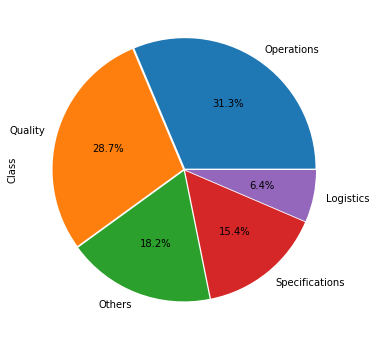

In [21]:
data_count = df['Class'].value_counts()
data_count.plot.pie(subplots=True, explode=[0.01,0.01,0.01,0.01,0.01],autopct='%1.1f%%',  figsize=(6, 6))

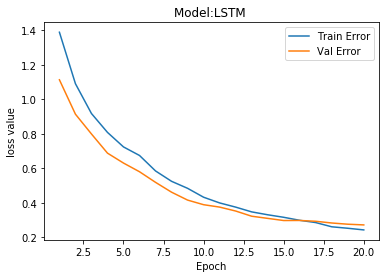

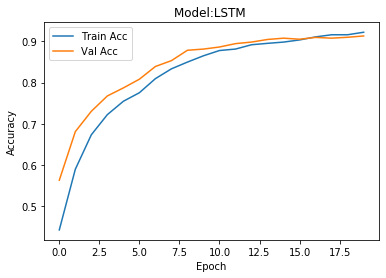

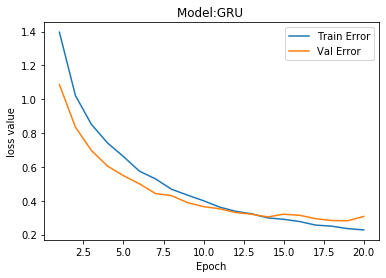

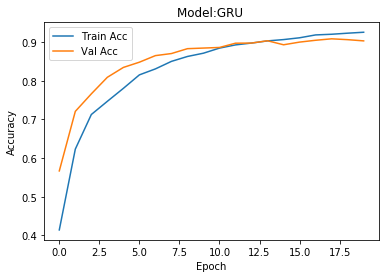

In [22]:
def drawPlot(title, history):
    iteration = 20
    plt.figure()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('loss value')
    plt.plot(range(1, iteration + 1),history['loss'],label='Train Error')
    plt.plot(range(1, iteration + 1),history['val_loss'],label='Val Error')
    plt.legend()
    plt.show()

    plt.figure()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(range(0,iteration),history['acc'],label='Train Acc')
    plt.plot(range(0,iteration),history['val_acc'],label='Val Acc')
    plt.legend()
    plt.show()
    
    
drawPlot("Model:LSTM ", history_LSTM.history)
drawPlot("Model:GRU ", history_GRU.history)


### RNN Model

In [23]:
model_RNN = Sequential()
model_RNN.add(Embedding(Max_Words, 300, weights=[embedding_matrix], input_length=100, trainable=True, mask_zero= True))
model_RNN.add(SimpleRNN(100, dropout=0.1, recurrent_dropout=0.1))
model_RNN.add(Dense(16, activation='relu'))
model_RNN.add(Dense(5, activation='softmax'))
model_RNN.compile(loss='sparse_categorical_crossentropy', optimizer= optimizers.Adam(1e-4), metrics=['accuracy'])
model_RNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          12661200  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               40100     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 85        
Total params: 12,703,001
Trainable params: 12,703,001
Non-trainable params: 0
_________________________________________________________________


In [24]:
filepath="RNN.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history_RNN = model_RNN.fit(pad_sequence_train, df['class_encoded'], epochs=20, validation_split= 0.2, batch_size=64,callbacks=callbacks_list)
model_RNN.load_weights("RNN.hdf5")

Train on 12682 samples, validate on 3171 samples
Epoch 1/20
12672/12682 [============================>.] - ETA: 0s - loss: 1.5743 - acc: 0.2972- ETA: 9s - loss: 1.6295 - - ETA: 8s - loss: 1.6221 - acc: 0.261 - ETA: 8s - los - ETA: 6s - 
Epoch 00001: val_loss improved from inf to 1.45423, saving model to RNN.hdf5
12682/12682 [==============================] - 21s 2ms/sample - loss: 1.5741 - acc: 0.2974 - val_loss: 1.4542 - val_acc: 0.3759
Epoch 2/20
12672/12682 [============================>.] - ETA: 0s - loss: 1.4381 - acc: 0.3949  ETA: 14s - loss - ETA: 11s - loss: 1.4632 -  - ETA: 9s - loss: 1.4611 - acc:  - ETA: 8s - loss: 1 - ETA: 6s - loss: 1.456 - ETA: 5s - los
Epoch 00002: val_loss improved from 1.45423 to 1.33898, saving model to RNN.hdf5
12682/12682 [==============================] - 20s 2ms/sample - loss: 1.4380 - acc: 0.3950 - val_loss: 1.3390 - val_acc: 0.4623
Epoch 3/20
12672/12682 [============================>.] - ETA: 0s - loss: 1.3278 - acc: 0.4758- ETA: 4s - los - ETA

12672/12682 [============================>.] - ETA: 0s - loss: 0.9278 - acc: 0.6577  ETA: 19s - loss: 0.9424 - a - E - ETA: 15s - loss: 0.9333 - acc:  - ETA: 15s - lo - - ETA: 12s - loss: 0.9312 - a - ETA: 10s - loss: 0.935 - ETA: 9s - loss: 0.9349 - acc: - ETA: 9s - loss: 0.9346 - - ETA: 4s - loss: 0.9340 - acc: 0.6 - ETA: 3s - loss: 0.9347 - acc: 0.652 - ETA: 3s - loss:  - ETA: 2s - loss: 0.9296 - acc: 0.65 - ETA: 1s - loss: 
Epoch 00019: val_loss improved from 0.93622 to 0.89964, saving model to RNN.hdf5
12682/12682 [==============================] - 20s 2ms/sample - loss: 0.9280 - acc: 0.6575 - val_loss: 0.8996 - val_acc: 0.6720
Epoch 20/20
12672/12682 [============================>.] - ETA: 0s - loss: 0.9579 - acc: 0.6475- E - ETA: 5s - ETA: 3s - lo - ETA: 1s - loss: 0.9582 
Epoch 00020: val_loss did not improve from 0.89964
12682/12682 [==============================] - 20s 2ms/sample - loss: 0.9579 - acc: 0.6476 - val_loss: 0.9696 - val_acc: 0.6468


In [25]:
RNN_Predicted_Y = model_RNN.predict_classes(pad_sequence_test)
RNN_Y_withlabels = label_encoder.inverse_transform(RNN_Predicted_Y)

In [26]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from statistics import mean 
print(accuracy_score(df_Test['class_encoded'],RNN_Predicted_Y))
# Print f1, precision, and recall scores
def getMetrics(y_test, y_pred):
    print(label_encoder.inverse_transform([0,1,2,3,4]))
    precision_list = precision_score(y_test, y_pred, average=None)
    print(precision_list)
    recall_list = recall_score(y_test, y_pred, average=None)
    print(recall_list)
    f1_score_list = f1_score(y_test, y_pred, average=None)
    print(f1_score_list)
    print("Precision: %f" %mean(precision_list) )
    print("recall_score: %f" %mean(recall_list) )
    print("f1_score: %f" %mean(f1_score_list) )

    
# LSTM_Predicted_Y
# df.class_encoded.tolist()
print("LSTM ")
getMetrics(df_Test.class_encoded.tolist(), LSTM_Predicted_Y)
print("\nGRU ")
getMetrics(df_Test.class_encoded.tolist(), GRU_Predicted_Y)
print("\nRNN ")
getMetrics(df_Test.class_encoded.tolist(), RNN_Predicted_Y)

0.5995009357454772
LSTM 
['Logistics' 'Operations' 'Others' 'Quality' 'Specifications']
[0.84313725 0.71879937 0.83223684 0.8816568  0.88053097]
[0.83495146 0.9063745  0.86643836 0.65065502 0.80241935]
[0.83902439 0.80176211 0.84899329 0.74874372 0.83966245]
Precision: 0.831272
recall_score: 0.812168
f1_score: 0.815637

GRU 
['Logistics' 'Operations' 'Others' 'Quality' 'Specifications']
[0.78571429 0.75767918 0.79127726 0.88957055 0.78294574]
[0.85436893 0.88446215 0.86986301 0.63318777 0.81451613]
[0.81860465 0.81617647 0.82871126 0.73979592 0.79841897]
Precision: 0.801437
recall_score: 0.811280
f1_score: 0.800341

RNN 
['Logistics' 'Operations' 'Others' 'Quality' 'Specifications']
[1.         0.54197531 0.62931034 0.66273585 0.664     ]
[0.11650485 0.87450199 0.5        0.61353712 0.33467742]
[0.20869565 0.66920732 0.55725191 0.63718821 0.44504021]
Precision: 0.699604
recall_score: 0.487844
f1_score: 0.503477


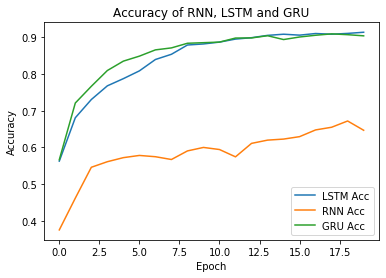

In [27]:
plt.figure()
plt.title("Accuracy of RNN, LSTM and GRU")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(0,20),history_LSTM.history['val_acc'],label='LSTM Acc')
plt.plot(range(0,20),history_RNN.history['val_acc'],label='RNN Acc')
plt.plot(range(0,20),history_GRU.history['val_acc'],label='GRU Acc')
plt.legend()
plt.show()
    